# Quantum Characterisation, Verification and Validation

To demonstrate how to implement new benchmarking experiments within the Superstaq QCVV framework,
consider implementing a naive benchmarking routine where we try to estimate the fidelity of a single
qubit Z gate by repeatedly applying the gate to a qubit in the ground state (such that the Z-gate
should have no effect) and observing if any observations of the excited state occur. If the excited 
state is observed this indicates an error has occurred. Assuming that each time the Z-gate is
applied the probability of a bit flip error is $e$ then after $d$ gates the probability of 
observing the ground state is $$p(0) = \frac{1}{2}(1-e)^d + \frac{1}{2}$$

We can create an experiment to measure this as follows

In [35]:
from cirq_superstaq.qcvv.base_experiment import BenchmarkingExperiment
from collections.abc import Sequence
from typing import Iterable, NamedTuple
from tqdm.contrib.itertools import product
import pandas as pd

import cirq

from scipy.stats import linregress
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from cirq_superstaq.qcvv.base_experiment import Sample


class NaiveExperimentResult(NamedTuple):
    gate_fidelity: float
    gate_error: float


class NaiveExperiment(BenchmarkingExperiment):
    def __init__(self):
        super().__init__(num_qubits=1)

    def build_circuits(self, num_circuits: int, layers: Iterable[int]) -> Sequence[Sample]:
        """Build the circuits by composing multiple Z gates together into circuits. The
        number of gates to compose is given by the `layers` parameter.
        """
        samples = []
        for _, depth in product(range(num_circuits), layers, desc="Building circuits."):
            circuit = cirq.Circuit([cirq.Z(*self.qubits) for _ in range(depth)])
            samples.append(Sample(circuit=circuit, data={"depth": depth}))
        return samples

    def process_probabilities(self) -> None:
        """Copy the data and observed probabilities into a pandas DataFrame."""
        super().process_probabilities()
        records = []
        for sample in self.samples:
            records.append({**sample.data, **sample.probabilities})
        self._raw_data = pd.DataFrame(records)

    def analyse_results(self, plot_results: bool = True) -> NamedTuple:
        """To analyse the results to fit a simple exponential decay. This can be done easily
        by fitting a linear model to the logarithm of the equation above.
        """

        model = linregress(x=self.raw_data["depth"], y=np.log(2 * self.raw_data["0"] - 1))

        fidelity = np.exp(model.slope)

        self._results = NaiveExperimentResult(gate_fidelity=fidelity, gate_error=1 - fidelity)

        if plot_results:
            self.plot_results()

        return self.results

    def plot_results(self) -> None:
        """Plot the data with the fit superimposed on top."""

        fig, axs = plt.subplots(
            1,
        )

        sns.scatterplot(self.raw_data, x="depth", y="0", ax=axs)

        x = np.linspace(0, max(self.raw_data.depth))
        y = 0.5 * self.results.gate_fidelity**x + 0.5
        axs.plot(x, y)

To test this basic experiment, we use a depolarising noise model and a density matrix simulator.
Note that if we use a single qubit depolarising channel with rate $p$ this will result in a bit-flip
error with probability of $4p/3$.

  0%|          | 0/200 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/200 [00:00<?, ?it/s]

NaiveExperimentResult(gate_fidelity=0.9867015465189143, gate_error=0.013298453481085715)

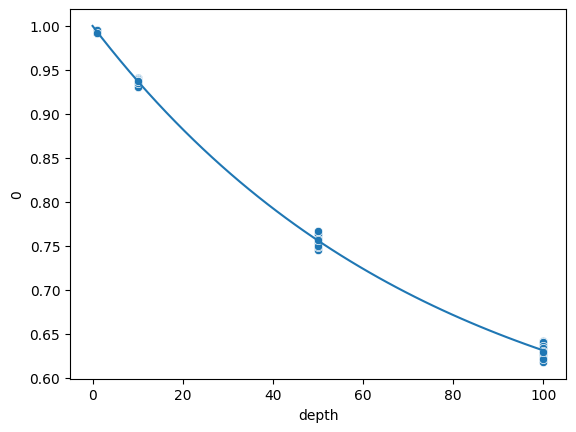

In [38]:
noise = cirq.DepolarizingChannel(p=0.01)
simulator = cirq.DensityMatrixSimulator(noise=noise)
experiment = NaiveExperiment()
experiment.run(50, [1, 10, 50, 100], target=simulator)
experiment.analyse_results(plot_results=True)

Checking this result we have

In [44]:
channel_rate = 3 / 4 * experiment.results.gate_error
print(channel_rate)

0.009973840110814286


Which agrees very closely with our channel rate of $0.01$